In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis/55.JPEG
/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis/130.JPEG
/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis/239.jpg
/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis/149.jpg
/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis/215.jpg
/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis/185.jpg
/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis/243.jpg
/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis/16.JPEG
/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis/153.jpg
/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis/232.png
/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis/189.jpg
/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis/143.jpg
/kaggle/input/osteoporosis-knee-xray-dataset/osteop

In [2]:
filepaths = []
labels = []
osteo_dir = r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis'
normal_dir = r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal'

for d in [osteo_dir, normal_dir]:
    flist=os.listdir(d)
    
    for f in flist:
        fpath=os.path.join(d,f)
        filepaths.append(fpath)
        
        if d == osteo_dir:
            labels.append('Osteoporosis')
        else:
            labels.append('Normal')
            
print ('Total number of images: ', len(labels))

Total number of images:  372


# Add files to dataframe

In [3]:
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

In [4]:
df = pd.concat([Fseries, Lseries], axis=1)
df.head()

,filepaths,labels
0,/kaggle/input/osteoporosis-knee-xray-dataset/o...,Osteoporosis
1,/kaggle/input/osteoporosis-knee-xray-dataset/o...,Osteoporosis
2,/kaggle/input/osteoporosis-knee-xray-dataset/o...,Osteoporosis
3,/kaggle/input/osteoporosis-knee-xray-dataset/o...,Osteoporosis
4,/kaggle/input/osteoporosis-knee-xray-dataset/o...,Osteoporosis


In [5]:
df['labels'].value_counts()

Osteoporosis    186
Normal          186
Name: labels, dtype: int64

Class distribution is equal

# Feature Selection

In [6]:
height=200
width=400
channels=3
batch_size=80
img_shape=(height, width, channels)
img_size=(height, width)
train_split=.9
test_split=.05

In [7]:
dummy_split = test_split/(1-train_split)
train_df, dummy_df = train_test_split(df, train_size = train_split, shuffle = True, random_state = 123)
test_df, valid_df = train_test_split(dummy_df, 
                                     train_size = dummy_split, 
                                     shuffle = True, 
                                     random_state = 123)
print ('train samples: ', len(train_df), '  test samples: ', len(test_df), ' validation samples', len(valid_df))

train samples:  334   test samples:  19  validation samples 19


In [8]:
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]

test_steps = int(length/test_batch_size)
print ('test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

test batch size:  19   test steps:  1


Data size is relatively small.
-----

Perform data augumentation to increase data size

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size)

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=test_batch_size)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size)

Found 334 validated image filenames belonging to 2 classes.
Found 19 validated image filenames belonging to 2 classes.
Found 19 validated image filenames belonging to 2 classes.


In [10]:
classes = list(train_gen.class_indices.keys())
class_count = len(classes)
train_steps = int(len(train_gen.labels)/batch_size)

# EDA

In [11]:
def show_image_samples(gen, class_names):
    class_dict = gen.class_indices
    new_dict = {}
    
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value] = key        
        
    images, labels = next(gen) # get a sample batch from the generator   
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = 15
    
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = class_names[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

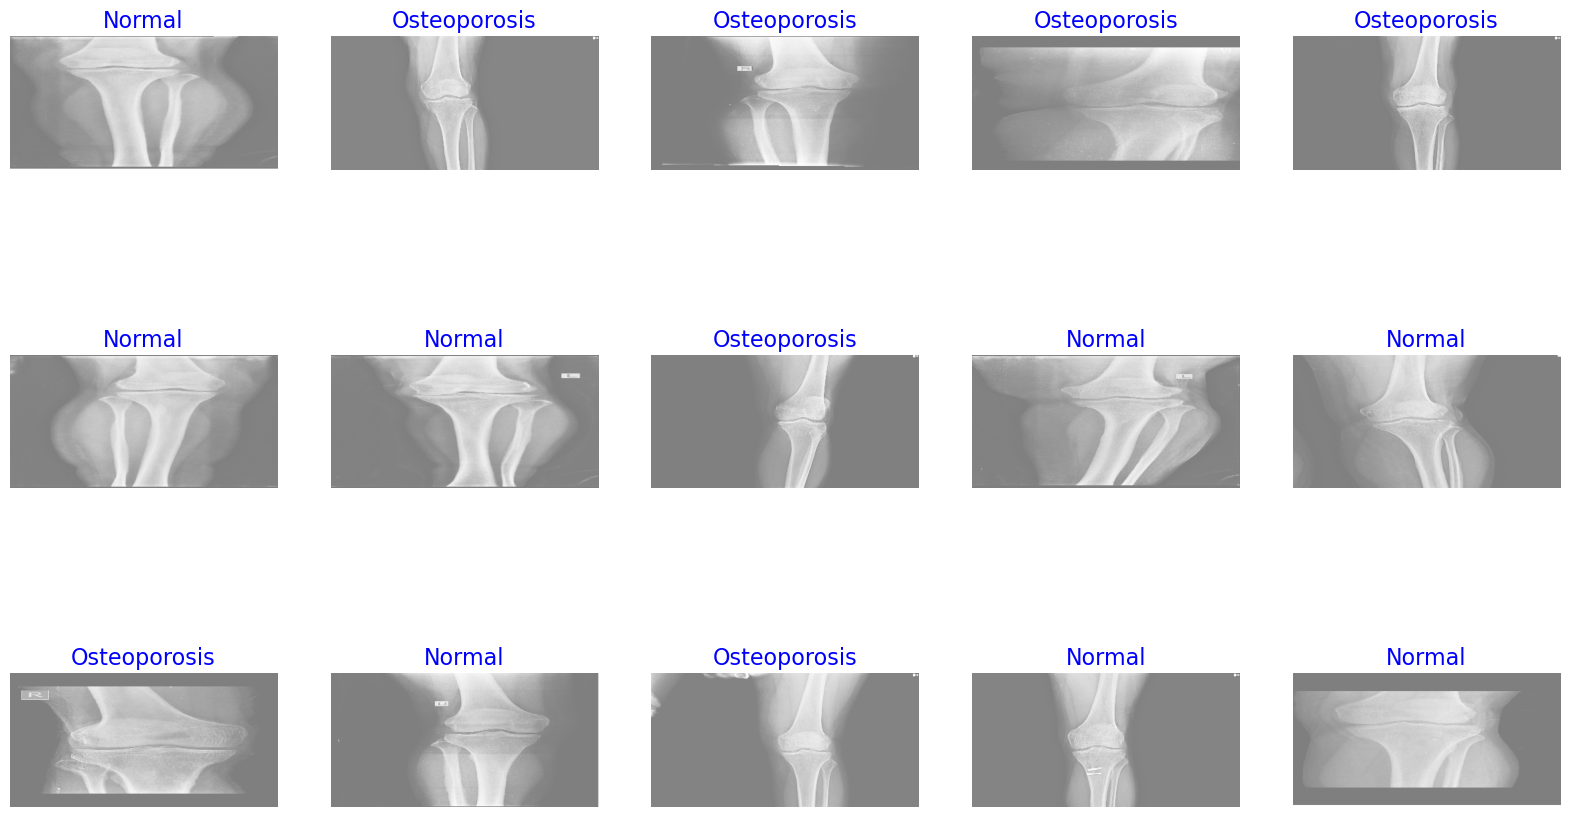

In [12]:
show_image_samples(test_gen, classes)

# Base

In [13]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(class_count, activation='sigmoid')
])

In [14]:
# Compile the model
model.compile(
    optimizer = Adam(),  # Use the Adam optimizer
    loss = "binary_crossentropy",  # Use categorical cross-entropy loss for multi-class classification
    metrics = ["accuracy"]  # Monitor the accuracy during training
)

In [15]:
# Train the model
history = model.fit(
    train_gen,  # Pass your training data
    validation_data = valid_gen,
    epochs=10,  # Set the number of epochs to train for
)

Epoch 1/10
5/5 [==============================] - 36s 4s/step - loss: 1.6199 - accuracy: 0.4940 - val_loss: 0.9379 - val_accuracy: 0.5263
Epoch 2/10
5/5 [==============================] - 17s 3s/step - loss: 0.7549 - accuracy: 0.5060 - val_loss: 0.6944 - val_accuracy: 0.5263
Epoch 3/10
5/5 [==============================] - 18s 3s/step - loss: 0.6942 - accuracy: 0.5060 - val_loss: 0.6927 - val_accuracy: 0.5263
Epoch 4/10
5/5 [==============================] - 17s 3s/step - loss: 0.6937 - accuracy: 0.5060 - val_loss: 0.6913 - val_accuracy: 0.5263
Epoch 5/10
5/5 [==============================] - 17s 3s/step - loss: 0.6921 - accuracy: 0.5060 - val_loss: 0.6887 - val_accuracy: 0.5263
Epoch 6/10
5/5 [==============================] - 17s 4s/step - loss: 0.6945 - accuracy: 0.5060 - val_loss: 0.6820 - val_accuracy: 0.5263
Epoch 7/10
5/5 [==============================] - 17s 4s/step - loss: 0.6864 - accuracy: 0.5090 - val_loss: 0.6774 - val_accuracy: 0.5263
Epoch 8/10
5/5 [==================

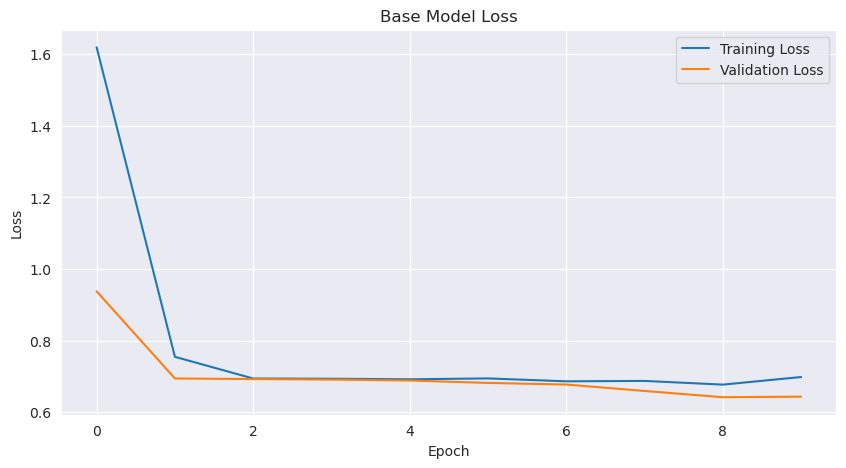

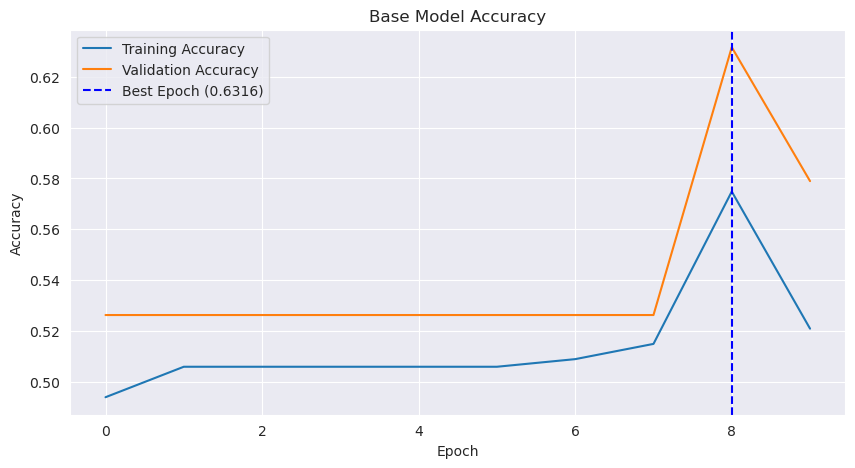

In [16]:
# Extract training and validation loss and accuracy from history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Find the index of the epoch with the best validation accuracy
best_epoch = val_acc.index(max(val_acc))

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Base Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Base Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Highlight the overall best epoch
best_val_acc = max(val_acc)
plt.axvline(x=val_acc.index(best_val_acc), color='blue', linestyle='--', label=f'Best Epoch ({best_val_acc:.4f})')

plt.legend()
plt.show()

# Evaluate

In [17]:
y_pred = model.predict(test_gen, steps=test_steps).argmax(axis=1)
y_true = test_gen.classes

weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Print the results
print('Weighted F1 score of both classes:', weighted_f1_score)
print('Accuracy of the model:', accuracy)

1/1 [==============================] - 1s 757ms/step
Weighted F1 score of both classes: 0.24439359267734553
Accuracy of the model: 0.3157894736842105


In [18]:
report = classification_report(y_true, y_pred)
print("Classification Report:\n----------------------\n", report)

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.33      0.08      0.13        12
           1       0.31      0.71      0.43         7

    accuracy                           0.32        19
   macro avg       0.32      0.40      0.28        19
weighted avg       0.33      0.32      0.24        19



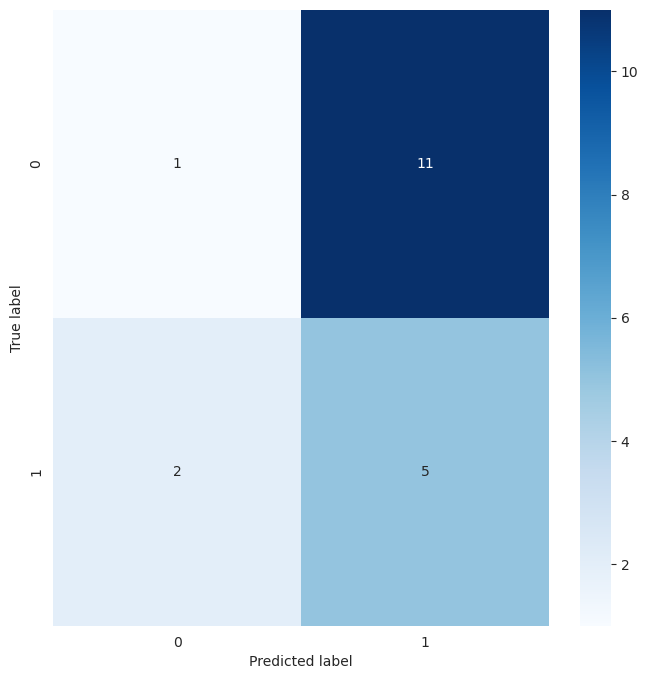

In [19]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Transfer Learning Model

In [20]:
# Load the pre-trained InceptionResNetV2 model with imagenet weights
incept_resnet_model = keras.applications.InceptionResNetV2(
    weights="imagenet",  # Load pre-trained weights on ImageNet
    input_shape=img_shape,  # Set input shape to match your dataset
    include_top=False  # Don't include the fully connected layer at the top of the network
)

# Freeze the base model layers to prevent them from being updated during training
incept_resnet_model.trainable = False

# Add your own classifier layers on top of the base model
inputs = keras.Input(shape=img_shape)
x = incept_resnet_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # Convert features to a single vector by averaging across spatial dimensions
x = Dense(256, activation="relu")(x)  # Add a dense layer with ReLU activation
outputs = Dense(class_count, activation="sigmoid")(x)  # Add a dense layer with softmax activation for classification

# Create the final model
model = keras.Model(inputs, outputs)

219055592/219055592 [==============================] - 1s 0us/step


In [21]:
# Compile the model
model.compile(
    optimizer= Adamax(),  # Use the Adam optimizer
    loss="binary_crossentropy",  # Use categorical cross-entropy loss for multi-class classification
    metrics=["accuracy"]  # Monitor the accuracy during training
)

In [22]:
# Train the model
history = model.fit(
    train_gen,  # Pass your training data
    validation_data = valid_gen,
    epochs=10,  # Set the number of epochs to train for
)

Epoch 1/10
5/5 [==============================] - 39s 4s/step - loss: 0.9743 - accuracy: 0.5419 - val_loss: 1.0371 - val_accuracy: 0.5263
Epoch 2/10
5/5 [==============================] - 18s 3s/step - loss: 0.8207 - accuracy: 0.5689 - val_loss: 0.5729 - val_accuracy: 0.7368
Epoch 3/10
5/5 [==============================] - 18s 3s/step - loss: 0.6964 - accuracy: 0.5629 - val_loss: 0.6155 - val_accuracy: 0.5789
Epoch 4/10
5/5 [==============================] - 18s 3s/step - loss: 0.6362 - accuracy: 0.6617 - val_loss: 0.5989 - val_accuracy: 0.6842
Epoch 5/10
5/5 [==============================] - 19s 4s/step - loss: 0.6621 - accuracy: 0.6198 - val_loss: 0.5248 - val_accuracy: 0.7368
Epoch 6/10
5/5 [==============================] - 18s 3s/step - loss: 0.5896 - accuracy: 0.6886 - val_loss: 0.5407 - val_accuracy: 0.6842
Epoch 7/10
5/5 [==============================] - 18s 3s/step - loss: 0.5695 - accuracy: 0.6886 - val_loss: 0.4935 - val_accuracy: 0.7368
Epoch 8/10
5/5 [==================

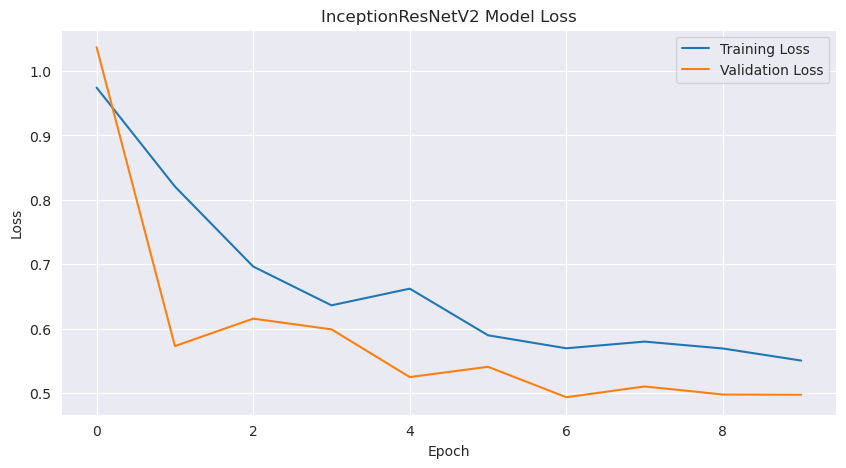

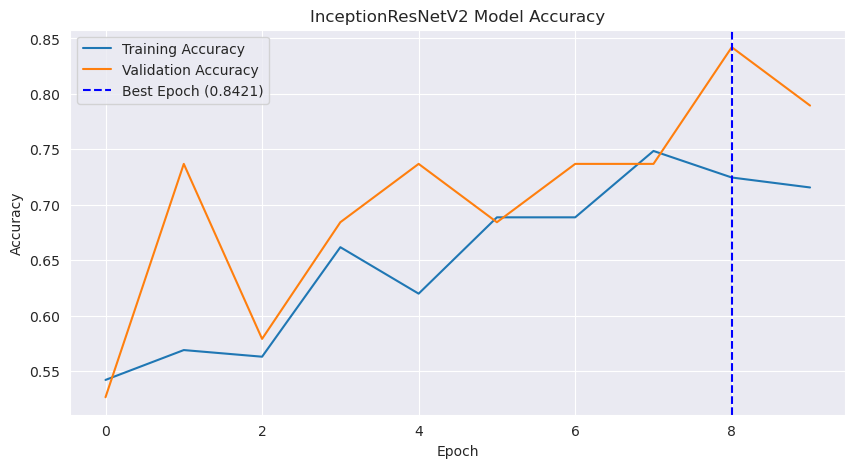

In [23]:
# Extract training and validation loss and accuracy from history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Find the index of the epoch with the best validation accuracy
best_epoch = val_acc.index(max(val_acc))

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('InceptionResNetV2 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('InceptionResNetV2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Highlight the overall best epoch
best_val_acc = max(val_acc)
plt.axvline(x=val_acc.index(best_val_acc), color='blue', linestyle='--', label=f'Best Epoch ({best_val_acc:.4f})')

plt.legend()
plt.show()

 #  Evaluate

In [24]:
y_pred = model.predict(test_gen, steps=test_steps).argmax(axis=1)
y_true = test_gen.classes

weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Print the results
print('InceptionResNetV2 Model Weighted F1 score of both classes:', weighted_f1_score)
print('InceptionResNetV2 Model Accuracy of the model:', accuracy)

1/1 [==============================] - 4s 4s/step
InceptionResNetV2 Model Weighted F1 score of both classes: 0.6877192982456141
InceptionResNetV2 Model Accuracy of the model: 0.6842105263157895


In [25]:
report = classification_report(y_true, y_pred)
print("Classification Report:\n----------------------\n", report)

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.55      0.86      0.67         7

    accuracy                           0.68        19
   macro avg       0.71      0.72      0.68        19
weighted avg       0.75      0.68      0.69        19



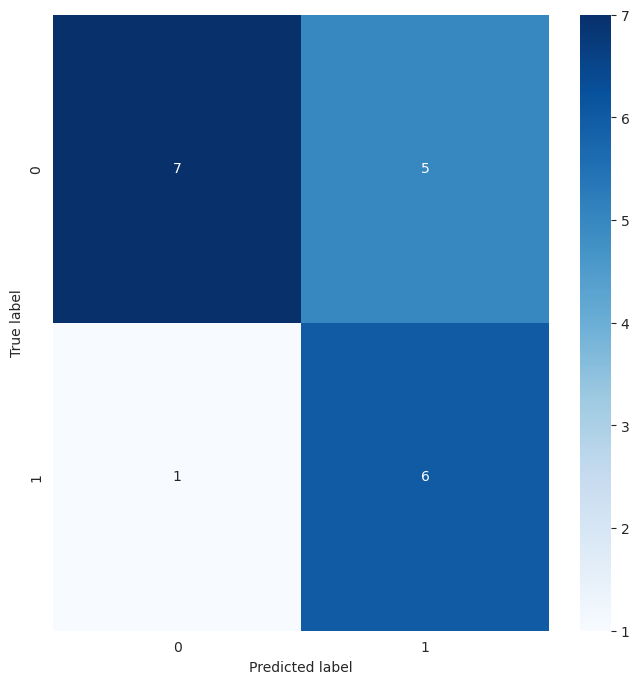

In [26]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()